## Logistic Regression Baseline (60/20/20 split)



In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

RANDOM_STATE = 42


### Step 1: Load Dataset

In [3]:
DATA_PATH = Path('churn_clean.csv')
df = pd.read_csv(DATA_PATH)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Step 2: Prepare Features and Target

In [4]:
X = df.drop('Exited', axis=1)
y = df['Exited']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols, num_cols


(['Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

### Step 3: Train/Validation/Test Split (60/20/20)

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print('Train:', X_train.shape, 'Target ratio:', y_train.mean().round(3))
print('Validation:', X_val.shape, 'Target ratio:', y_val.mean().round(3))
print('Test:', X_test.shape, 'Target ratio:', y_test.mean().round(3))


Train: (6000, 10) Target ratio: 0.204
Validation: (2000, 10) Target ratio: 0.204
Test: (2000, 10) Target ratio: 0.204


### Step 4: Build Pipeline

In [6]:
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer([
    ('categorical', ohe, cat_cols),
    ('numeric', StandardScaler(), num_cols)
])

log_reg_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        max_iter=1000,
        solver='liblinear',
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])
log_reg_pipeline


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Step 5: Train Model

In [7]:
log_reg_pipeline.fit(X_train, y_train)
log_reg_pipeline


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Step 6: Evaluate on Validation and Test Sets

In [8]:
y_val_pred = log_reg_pipeline.predict(X_val)
y_val_proba = log_reg_pipeline.predict_proba(X_val)[:, 1]
y_test_pred = log_reg_pipeline.predict(X_test)
y_test_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]


In [9]:
print('Validation ROC-AUC:', round(roc_auc_score(y_val, y_val_proba), 3))
print(classification_report(y_val, y_val_pred))
print('Test ROC-AUC:', round(roc_auc_score(y_test, y_test_proba), 3))
print(classification_report(y_test, y_test_pred))


Validation ROC-AUC: 0.794
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1592
           1       0.40      0.75      0.52       408

    accuracy                           0.72      2000
   macro avg       0.66      0.73      0.66      2000
weighted avg       0.81      0.72      0.74      2000

Test ROC-AUC: 0.773
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1593
           1       0.37      0.70      0.49       407

    accuracy                           0.70      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.79      0.70      0.73      2000



In [10]:
val_cm = confusion_matrix(y_val, y_val_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
val_cm, test_cm


(array([[1134,  458],
        [ 104,  304]]),
 array([[1115,  478],
        [ 123,  284]]))

### Step 7: Visual Diagnostics

In [11]:
FIG_DIR = Path('figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [12]:
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)
val_auc = roc_auc_score(y_val, y_val_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

val_prec, val_rec, _ = precision_recall_curve(y_val, y_val_proba)
test_prec, test_rec, _ = precision_recall_curve(y_test, y_test_proba)
val_ap = average_precision_score(y_val, y_val_proba)
test_ap = average_precision_score(y_test, y_test_proba)


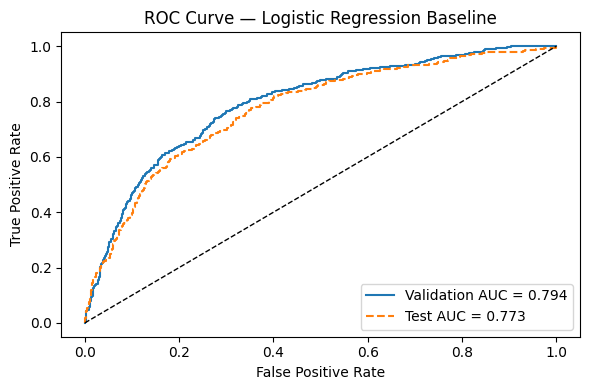

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(val_fpr, val_tpr, label=f'Validation AUC = {val_auc:.3f}')
plt.plot(test_fpr, test_tpr, label=f'Test AUC = {test_auc:.3f}', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression Baseline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve_logreg_baseline.png', dpi=200)
plt.show()


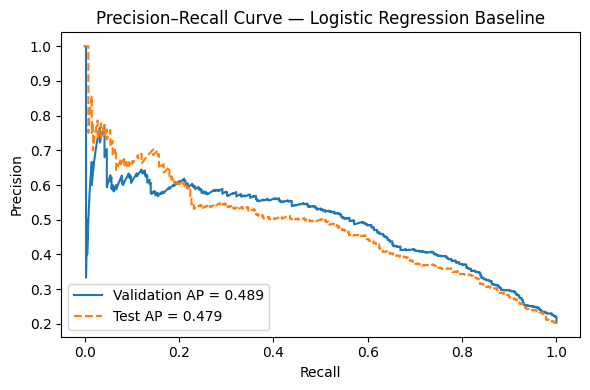

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(val_rec, val_prec, label=f'Validation AP = {val_ap:.3f}')
plt.plot(test_rec, test_prec, label=f'Test AP = {test_ap:.3f}', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve — Logistic Regression Baseline')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(FIG_DIR / 'pr_curve_logreg_baseline.png', dpi=200)
plt.show()


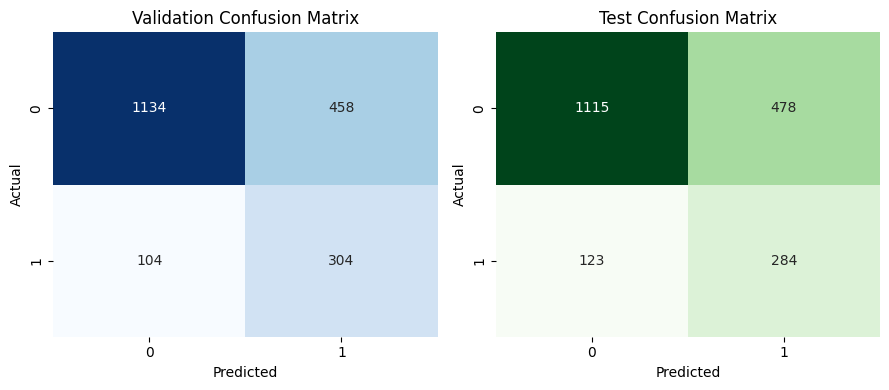

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Validation Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrices_logreg_baseline.png', dpi=200)
plt.show()


### Step 8: Inspect Coefficients

In [16]:
coef = log_reg_pipeline.named_steps['model'].coef_[0]
feature_names = log_reg_pipeline.named_steps['preprocess'].get_feature_names_out()
coef_series = pd.Series(coef, index=feature_names)
coef_series.sort_values(key=lambda s: s.abs(), ascending=False).head(15)


numeric__Age                      0.792098
categorical__Geography_Germany    0.466788
numeric__IsActiveMember          -0.427306
categorical__Geography_France    -0.299704
categorical__Gender_Male         -0.295631
categorical__Geography_Spain     -0.262320
categorical__Gender_Female        0.200395
numeric__Balance                  0.179055
numeric__CreditScore             -0.110653
numeric__EstimatedSalary          0.044127
numeric__Tenure                  -0.010713
numeric__NumOfProducts           -0.010064
numeric__HasCrCard               -0.007314
dtype: float64

### Step 9: Persist Model

In [17]:
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / 'log_reg_baseline.joblib'
joblib.dump(log_reg_pipeline, MODEL_PATH)
MODEL_PATH


PosixPath('models/log_reg_baseline.joblib')